In [3]:
import os
%pip install wget
import wget
import zipfile
import torchvision.datasets as datasets

In [4]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)    #creates a folder for storing the data if it didn't already exist

for file in file_list:    #iterates over files in file list
    url = f"{base_url}/{file}"    #creates a url for each file
    if not os.path.exists(f"{dataset_folder}/{file}"):    #if the file is not downloaded
        wget.download(url, f"{dataset_folder}/{file}")    #downlaod file

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:    #extracts all the zipped images
    ziphandler.extractall(dataset_folder)

In [5]:
import torchvision.transforms as T

image_size = 64
batch_size = 64 # this means the dataset will be broken into groups of 64 images
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transforms = T.Compose([T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])

train_dataset_images = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"])
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"], transform=transforms)

In [6]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

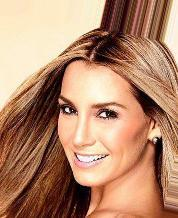

In [7]:
train_dataset_images[0][0]

In [8]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

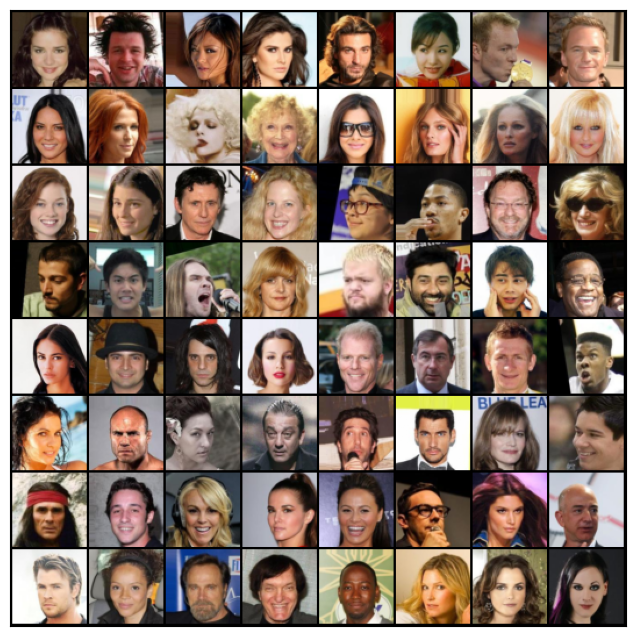

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
def denorm(img_tensors): # we will see this later
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64): # to show images
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=64): # to show a batch of images (no = batch size)
    for images in dataloader:
        show_images(images, nmax)
        break
show_batch(train_data_loader)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_data_loader = DeviceDataLoader(train_data_loader, device) # this is the actual dataloader

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Stride denotes how many steps we are moving in each step in convolution.
    nn.BatchNorm2d(64),                                                # Padding is a process of adding zeros to the input matrix symmetrically used to to maintain the dimension of output as in input
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32



    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten the previous outputs
    nn.Flatten(),
    nn.Sigmoid())

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    # 2D Convolution Transpose: in_channels=?, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + ReLU
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    # 2D Convolution Transpose: in_channels=?, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + ReLU
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # Use Tanh activation
    nn.Tanh()
    # out: 3 x 64 x 64
)
generator = to_device(generator, device)

torch.Size([64, 3, 64, 64])


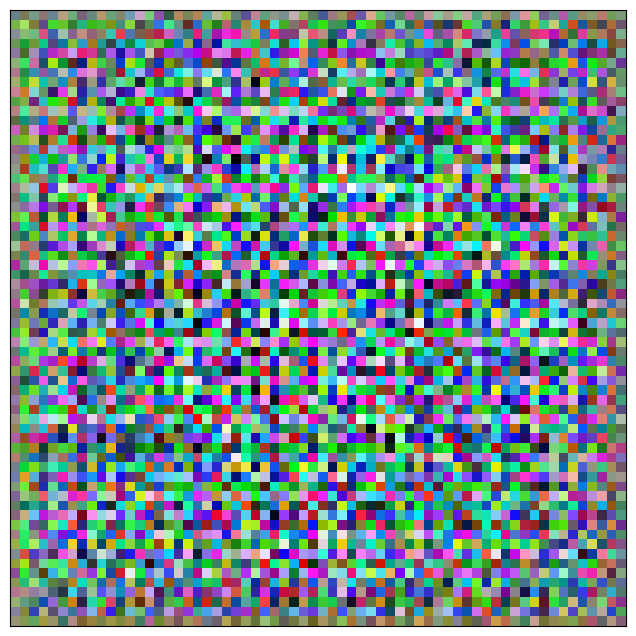

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward() # Compute the gradients using .backward() method
    opt_g.step()    # Perform the Gradient Descent using optimizer.step()

    return loss.item()

In [19]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [20]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache() # getting rid of cache to save memory

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, real_images in enumerate(tqdm(train_data_loader)):
            # Train discriminator
            if i%3==0:
                loss_d, real_score, fake_score = train_discriminator(real_images[0], opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    return losses_g, losses_d, real_scores, fake_scores

In [21]:
fit(epochs=6, lr=0.0002)

  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [1/6], loss_g: 0.7060, loss_d: 1.4098, real_score: 0.5004, fake_score: 0.4903


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [2/6], loss_g: 0.9953, loss_d: 1.3018, real_score: 0.5757, fake_score: 0.5068


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [3/6], loss_g: 0.8239, loss_d: 1.2967, real_score: 0.5212, fake_score: 0.4537


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [4/6], loss_g: 0.9871, loss_d: 1.0379, real_score: 0.6753, fake_score: 0.4639


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [5/6], loss_g: 1.0842, loss_d: 1.1778, real_score: 0.5062, fake_score: 0.3648


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch [6/6], loss_g: 1.1194, loss_d: 1.1560, real_score: 0.6320, fake_score: 0.4765


([0.706034779548645,
  0.995333194732666,
  0.8238991498947144,
  0.9871201515197754,
  1.0841631889343262,
  1.1193647384643555],
 [1.4097809791564941,
  1.3017563819885254,
  1.2966539859771729,
  1.0379176139831543,
  1.177837610244751,
  1.156040906906128],
 [0.5004385709762573,
  0.5757138729095459,
  0.5211527347564697,
  0.6752653121948242,
  0.5061757564544678,
  0.6319933533668518],
 [0.49030449986457825,
  0.5068039298057556,
  0.4536847472190857,
  0.46385687589645386,
  0.364818274974823,
  0.47647690773010254])

torch.Size([64, 3, 64, 64])


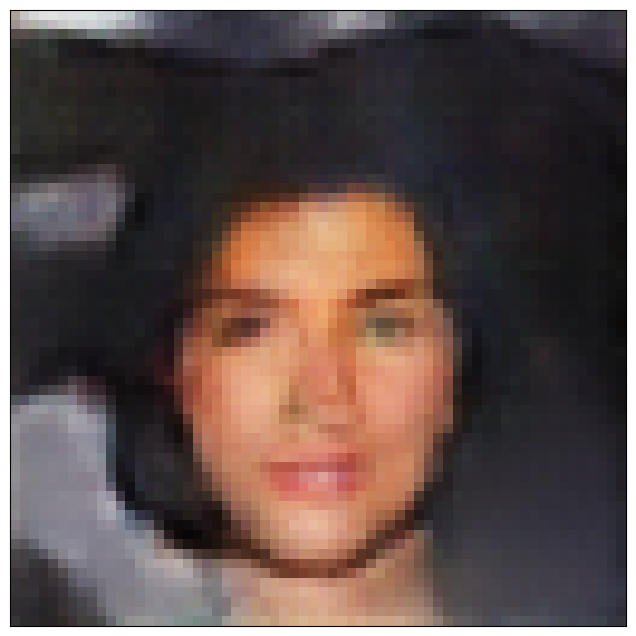

In [22]:
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

torch.Size([64, 3, 64, 64])


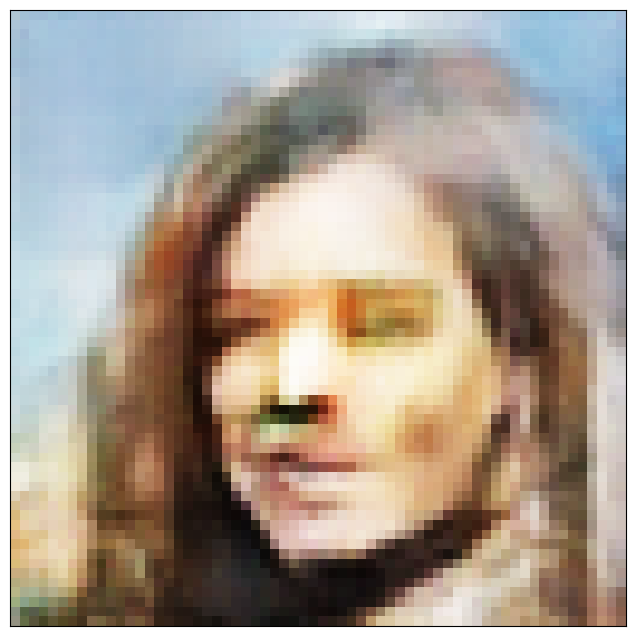

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())